# Model Monitoring for Cardiac Image Segmentation

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA TITAN Xp (UUID: GPU-213e830e-812c-d8af-3404-f3b75c03543e)


In [2]:
import random
import numpy as np
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Install requirements

#### batchgenerators

In [ ]:
%pip install --upgrade batchgenerators

#### medpy

In [ ]:
%pip install medpy

#### nibabel

In [ ]:
%pip install nibabel

## Import data
### Heart segmentation

In [10]:
import os

# TODO : have a clearner way of handling the "/"
def get_download_model_command(file_id, file_name, directory):
    save_path= os.path.join(os.getcwd(),directory)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

In [ ]:
MODEL_PATHS = {
    "training": {"id": "1bxRj0zf-iMooYA4jUZS_zS4VD9NLYxE4", "name": "training.zip"},
    "testing": {"id": "1L84oEmgc2Nd10bCBlaM7vkbl7nhrYC9I", "name": "testing.zip"},
    "predictions": {"id": "1P2kNGllKUKmumaCM2IsqgIgRPAKEXa59", "name": "predictions.zip"},
    "measures": {"id": "1ss-qGFEocJT-h3JAebcDjeWBQXcxPs0T", "name": "measures.zip"}
}

if not os.path.exists("./data/heart") :
    os.mkdir('./data/heart')
    for path in MODEL_PATHS.values():
        download_command = get_download_model_command(file_id=path["id"], file_name=path["name"], directory="data/heart")
        !{download_command}


In [8]:
if not os.path.exists('./data/heart/training'):
    unzip_command="""unzip -q data/heart/training.zip -d data/heart"""
    !{unzip_command}

In [7]:
if not os.path.exists('./data/heart/testing'):
    unzip_command="""unzip -q data/heart/testing.zip -d data/heart/"""
    remove_extended_tree="""mv data/heart/testing/testing data/tmp && rm -r data/heart/testing && mv data/tmp data/heart/testing"""
    !{unzip_command}
    !{remove_extended_tree}

In [6]:
if not os.path.exists('./data/heart/predictions'):
    unzip_command="""unzip -q data/heart/predictions.zip -d data/heart"""
    !{unzip_command}

In [5]:
if not os.path.exists('./data/heart/measures'):
    unzip_command="""unzip -q data/heart/measures.zip -d data/heart"""
    !{unzip_command}

## Data preparation

In [3]:
import os
import numpy as np
from utils.utilsAcdc import generate_patient_info, preprocess

In [2]:
patient_info = generate_patient_info("data/heart/training/", patient_ids=range(1, 101))
patient_info = {**patient_info, **generate_patient_info("data/heart/testing/", patient_ids=range(101, 151))}

if not os.path.exists("preprocessed/"):
    os.makedirs("preprocessed/")
np.save(os.path.join("preprocessed/", "patient_info"), patient_info)

In [11]:
#spacings = [patient_info[id]["spacing"] for id in range(1, 101)]
#spacing_target = np.percentile(np.vstack(spacings), 50, 0)
spacing_target = [10, 1.25, 1.25]

if not os.path.exists("preprocessed/training/"):
    os.makedirs("preprocessed/training/")
preprocess(
    range(1,101), patient_info, spacing_target,
    "data/training", "preprocessed/training",
    lambda folder, id: os.path.join(folder, 'patient{:03d}'.format(id)),
    lambda patient_info, id, phase: "patient{:03d}_frame{:02d}_gt.nii.gz".format(id, patient_info[id][phase])
)

In [12]:
for model in os.listdir("data/predictions/"):
    if not os.path.exists("preprocessed/predictions/{}".format(model)):
        os.makedirs("preprocessed/predictions/{}".format(model))
    preprocess(
        range(101,151), patient_info, spacing_target,
        "data/predictions/{}".format(model), "preprocessed/predictions/{}".format(model),
        lambda folder, id: folder,
        lambda patient_info, id, phase: "patient{:03d}_{}.nii.gz".format(id,phase)
    ) 

## Dataset

In [7]:
import os
import numpy as np
import random
import torchvision
from utils.utilsAcdc import AddPadding, CenterCrop, OneHot, ToTensor, MirrorTransform, SpatialTransform

In [8]:
ids = random.sample(range(1, 101), 100)
train_ids = ids[:80]
val_ids = ids[80:]

transform = torchvision.transforms.Compose([
    AddPadding((256,256)),
    CenterCrop((256,256)),
    OneHot(),
    ToTensor()
])
transform_augmentation = torchvision.transforms.Compose([
    MirrorTransform(),
    SpatialTransform(patch_size=(256,256), angle_x=(-np.pi/6,np.pi/6), scale=(0.7,1.4), random_crop=True),
    OneHot(),
    ToTensor()
])

## Training

In [4]:
import sys, importlib
import CA
importlib.reload(sys.modules['CA'])

import torch
from CA import AE, plot_history, hyperparameter_tuning
from utils.utilsAcdc import ACDCDataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#the following cell allows the user to tune his own hyperparameters. In case you wanna try our hyperparameters first, just skip this cell.

#this is a list of possible values being tested for each hyperparameter.
parameters = {
    "DA": [True, False], #data augmentation
    "latent_size": [100, 500], #size of the latent space of the autoencoder
    "BATCH_SIZE": [8, 16, 4],
    "optimizer": [torch.optim.Adam],
    "lr": [2e-4, 1e-4, 1e-3],
    "weight_decay": [1e-5],
    "tuning_epochs": [5, 10], #number of epochs each configuration is run for
    "functions": [["GDLoss", "MSELoss"], ["GDLoss"], ["BKGDLoss", "BKMSELoss"]], #list of loss functions to be evaluated. BK stands for "background", which is a predominant and not compulsory class (it can lead to a dumb local minimum retrieving totally black images).
    "settling_epochs_BKGDLoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKGDLoss
    "settling_epochs_BKMSELoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKMSELoss
}

#this is a list of rules cutting out some useless combinations of hyperparameters from the tuning process.
rules = [
    '"settling_epochs_BKGDLoss" == 0 or "BKGDLoss" in "functions"',
    '"settling_epochs_BKMSELoss" == 0 or "BKMSELoss" in "functions"',
    '"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" <= "tuning_epochs"',
    '"BKMSELoss" not in "functions" or "settling_epochs_BKMSELoss" <= "tuning_epochs"',
    #'"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" >= "settling_epochs_BKMSELoss"'
]

optimal_parameters = hyperparameter_tuning(
    parameters,
    ACDCDataLoader("preprocessed/training", patient_ids=train_ids, batch_size=None, transform=None),
    ACDCDataLoader("preprocessed/training", patient_ids=val_ids, batch_size=None, transform=None),
    transform, transform_augmentation,
    rules,
    fast=True) #very important parameter. When False, all combinations are tested to return the one retrieving the maximum DSC. When True, the first combination avoiding dumb local minima is returned.

np.save(os.path.join("preprocessed/", "optimal_parameters"), optimal_parameters)

In [1]:
upload_your_own_parameters = False

if upload_your_own_parameters:
    optimal_parameters = np.load(os.path.join("preprocessed", "optimal_parameters.npy"), allow_pickle=True).item()
else:
    optimal_parameters = {
        "BATCH_SIZE": 8,
        "DA": False,
        "latent_size": 100,
        "optimizer": torch.optim.Adam,
        "lr": 2e-4,
        "weight_decay": 1e-5,
        "functions": ["BKGDLoss", "BKMSELoss"],
        "settling_epochs_BKGDLoss": 10,
        "settling_epochs_BKMSELoss": 0
    }
    np.save(os.path.join("preprocessed/", "optimal_parameters"), optimal_parameters)

assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

BATCH_SIZE = optimal_parameters["BATCH_SIZE"]
DA = optimal_parameters["DA"]

ae = AE(**optimal_parameters).to(device)

ckpt = 'checkpoints/490_best.pth'
if ckpt is not None:
    ckpt = torch.load(ckpt)
    ae.load_state_dict(ckpt["AE"])
    ae.optimizer.load_state_dict(ckpt["AE_optim"])
    start = ckpt["epoch"]+1
else:
    start = 0

print(ae)

plot_history(
    ae.training_routine(
        range(start, 500),
        ACDCDataLoader("preprocessed/training", patient_ids=train_ids, batch_size=BATCH_SIZE, transform=transform_augmentation if DA else transform),
        ACDCDataLoader("preprocessed/training", patient_ids=val_ids, batch_size=BATCH_SIZE, transform=transform),
        "checkpoints/"
    )
)

NameError: name 'torch' is not defined

## Testing

In [3]:
import os
import numpy as np
import torch
import nibabel as nib
from CA import AE
from utils.utilsAcdc import testing, display_image, display_difference, process_results, display_plots, ACDCDataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Run if you skip the training part

optimal_parameters = {
        "BATCH_SIZE": 8,
        "DA": False,
        "latent_size": 100,
        "optimizer": torch.optim.Adam,
        "lr": 2e-4,
        "weight_decay": 1e-5,
        "functions": ["BKGDLoss", "BKMSELoss"],
        "settling_epochs_BKGDLoss": 10,
        "settling_epochs_BKMSELoss": 0
    }
np.save(os.path.join("preprocessed/", "optimal_parameters"), optimal_parameters)
BATCH_SIZE = optimal_parameters["BATCH_SIZE"]
DA = optimal_parameters["DA"]

In [8]:
# optimal_parameters = np.load(os.path.join("preprocessed", "optimal_parameters.npy"), allow_pickle=True).item()
assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

ckpt = os.path.join("checkpoints", sorted([file for file in os.listdir("checkpoints") if "_best" in file])[-1])
ckpt = torch.load(ckpt)

ae = AE(**optimal_parameters).to(device)
ae.load_state_dict(ckpt["AE"])
ae.optimizer.load_state_dict(ckpt["AE_optim"])
ae.eval();

In [9]:
patient_info = np.load("preprocessed/patient_info.npy", allow_pickle=True).item()
#spacings = [patient_info[id]["spacing"] for id in range(1, 101)]
#current_spacing = np.percentile(np.vstack(spacings), 50, 0)
current_spacing = [10, 1.25, 1.25]

In [14]:
test_loaders = {}
for model in os.listdir("preprocessed/predictions/"):
    test_loaders[model] = ACDCDataLoader("preprocessed/predictions/{}".format(model), patient_ids=range(101, 151), batch_size=BATCH_SIZE, transform=transform)

if not os.path.exists("postprocessed/measures"):
    os.makedirs("postprocessed/measures")
for model in sorted(test_loaders.keys()):
    if not os.path.exists("postprocessed/predictions/{}".format(model)):
        os.makedirs("postprocessed/predictions/{}".format(model))
    results = testing(ae, test_loaders[model], patient_info, "data/predictions/{}".format(model), "postprocessed/predictions/{}".format(model), current_spacing)
    np.save("postprocessed/measures/{}_AE.npy".format(model), results)

### Single patient

In [19]:
model = "Bai"
patient_id = 102
phase = "ED"

prediction = nib.load("data/predictions/{}/patient{:03d}_{}.nii.gz".format(model, patient_id, phase)).get_fdata().transpose(2, 1, 0)
reconstruction = nib.load("postprocessed/predictions/{}/patient{:03d}_{}.nii.gz".format(model, patient_id, phase)).get_fdata().transpose(2, 1, 0)

In [2]:
from utils.utilsAcdc import display_image, display_difference
display_image(prediction[2])

NameError: name 'prediction' is not defined

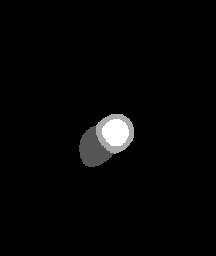

In [21]:
display_image(reconstruction[2])

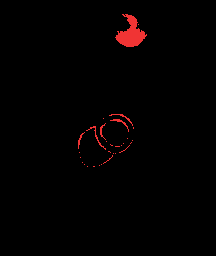

In [22]:
display_difference(prediction[2], reconstruction[2])

### Plots

In [5]:
models = ["Bai", "Baumgartner", "Grinias", "Isensee", "Khened", "Yang"]
plots = process_results(models, "data/heart/measures/", "postprocessed/measures/")

Anomalies (DSC=0/HD=nan): 16
Spotted by CA: 15
False Positive by CA: 3
Total discarded from the next plots: 19


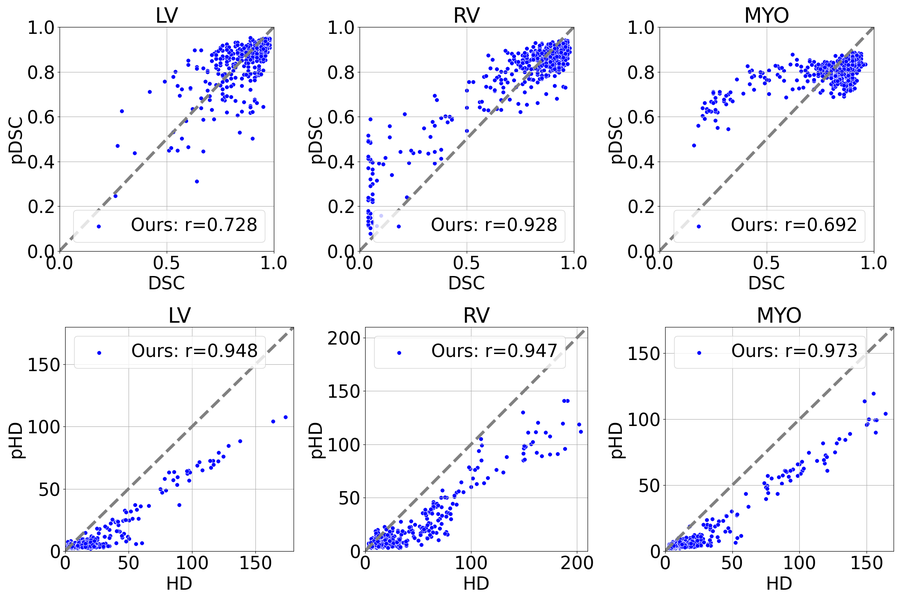

In [6]:
display_plots(plots)